# The Transient Universe

In [1]:
import dynesty

In [2]:
import dynesty
import numpy as np

# Define the dimensionality of our problem.
ndim = 4

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

In [3]:
C

array([[1.  , 0.95, 0.95],
       [0.95, 1.  , 0.95],
       [0.95, 0.95, 1.  ]])

In [4]:
def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm # Notice I need the correct normalization now! 
 
# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

In [5]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

4811it [00:04, 1145.33it/s, +500 | bound: 8 | nc: 1 | ncall: 24112 | eff(%): 22.493 | loglstar:   -inf < -0.308 <    inf | logz: -9.143 +/-  0.129 | dlogz:  0.001 >  0.509]


In [9]:
import numpy as np
from scipy import stats, interpolate
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import optimize
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [4, 4]


from scipy.stats import cauchy
import emcee


In [10]:
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
d_flux = x[:,2]

<ErrorbarContainer object of 3 artists>

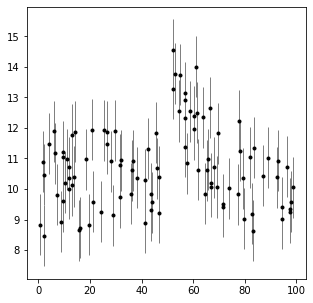

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='gray')


The data are homoscedastic

In [12]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

def model(t, x):
    b, A, to, alpha  = x
    return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))


#likelihood assuming a gaussian flux[i]- model profuttoria exp(-(f-model)^2/sigma^2)

emcee wants function

In [22]:
import dynesty
ndim = 4

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix

In [23]:
def model(t, x1, x2, x3, x4):
    b, A, to, alpha  = x1, x2, x3, x4
    return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))


#likelihood assuming a gaussian flux[i]- model profuttoria exp(-(f-model)^2/sigma^2)

In [24]:
popt, pcov = curve_fit(model, time, flux, sigma = d_flux) 

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_3972\201356744.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))


In [25]:
def LogLikelihood(x, flux, d_flux ):
    y = model(time, x)
    #-0.5 * np.sum((y-y_fit)**2 / sigma_y**2 
    return -0.5*np.sum((flux-y)**2 / d_flux**2) 


def LogPrior(x):
    b,A,t0,alpha = x
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 -np.log(alpha)
    else: 
        return -np.inf

def myLogPosterior(x, flux, d_flux):
    return LogLikelihood(x, flux, d_flux) + LogPrior(x)


In [26]:
ndim = 4  # number of parameters in the model
nwalkers = 24  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = x_quick + 1e-1* np.random.randn(nwalkers, ndim)
#starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[flux, d_flux])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

C:\Users\LEONARDO\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\LEONARDO\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


done
done


In [27]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(24, 100000, 4)
(2160000, 4)
(24, 100000, 4)
(2160000, 4)


In [28]:
print(emcee_trace)

[[10.32675654  5.2732372  49.32753083  0.11646348]
 [10.35695884  5.11998594 49.46816447  0.12658248]
 [10.39275516  5.83613129 48.42601147  0.13429456]
 ...
 [10.40454504  7.04946262 47.96463636  0.1291931 ]
 [10.33997745  6.11039695 47.73829588  0.11005548]
 [10.33997745  6.11039695 47.73829588  0.11005548]]
[[10.32675654  5.2732372  49.32753083  0.11646348]
 [10.35695884  5.11998594 49.46816447  0.12658248]
 [10.39275516  5.83613129 48.42601147  0.13429456]
 ...
 [10.40454504  7.04946262 47.96463636  0.1291931 ]
 [10.33997745  6.11039695 47.73829588  0.11005548]
 [10.33997745  6.11039695 47.73829588  0.11005548]]


In [29]:
b = emcee_trace[:,0]
A = emcee_trace[:,1]
to = emcee_trace[:,2]
alpha = emcee_trace[:,3]
print(b)
print(A)
print(to)
print(alpha)


[10.32675654 10.35695884 10.39275516 ... 10.40454504 10.33997745
 10.33997745]
[5.2732372  5.11998594 5.83613129 ... 7.04946262 6.11039695 6.11039695]
[49.32753083 49.46816447 48.42601147 ... 47.96463636 47.73829588
 47.73829588]
[0.11646348 0.12658248 0.13429456 ... 0.1291931  0.11005548 0.11005548]
[10.32675654 10.35695884 10.39275516 ... 10.40454504 10.33997745
 10.33997745]
[5.2732372  5.11998594 5.83613129 ... 7.04946262 6.11039695 6.11039695]
[49.32753083 49.46816447 48.42601147 ... 47.96463636 47.73829588
 47.73829588]
[0.11646348 0.12658248 0.13429456 ... 0.1291931  0.11005548 0.11005548]


In [30]:
print(len(b))

2160000
2160000


## Print

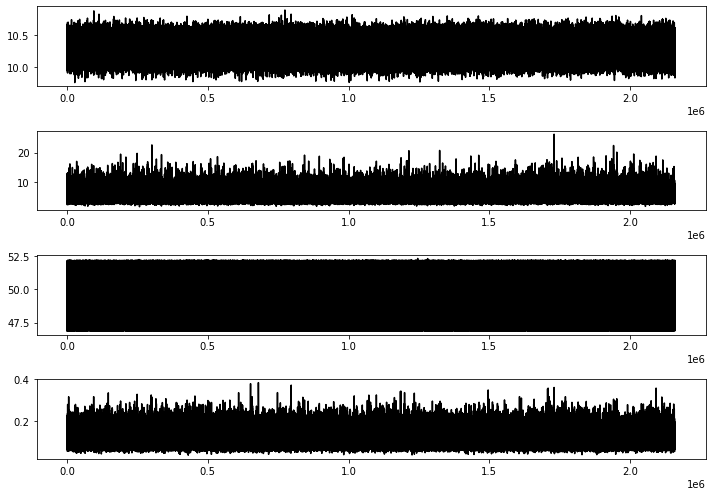

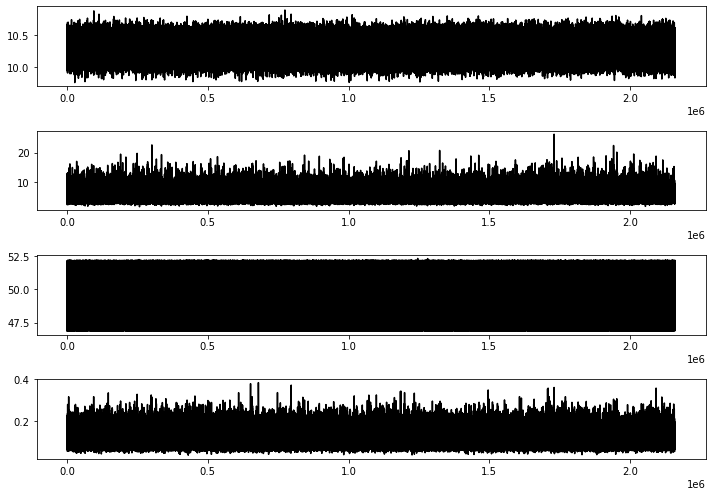

In [31]:
fig, ax= plt.subplots(4, figsize=(10, 7))#, sharex=True)
ax[0].plot(b, color='black')
ax[1].plot(A, color='black')
ax[2].plot(to, color='black')
ax[3].plot(alpha, color='black')
#ax1.set_xlabel('N')
#ax1.set_ylabel('Difference value')
#ax1.set_title('Error trend')



fig.tight_layout()
plt.show()

# Now take one point every autocorrelation lenght

In [32]:
# Now take one point every autocorrelation lenght
tau = sampler.get_autocorr_time()
print(tau)
thin = tau.astype(int) +1 
print(thin)

[59.75551364 81.77010018 78.82249301 67.18208801]
[60 82 79 68]
[59.75551364 81.77010018 78.82249301 67.18208801]
[60 82 79 68]


In [33]:
new_samples = sampler.get_chain(discard=int(burn/max(thin)), thin = max(thin), flat=True)
print(new_samples.shape)

(29232, 4)
(29232, 4)


In [34]:
print(new_samples[0])

[10.2930241   4.09956393 50.44652223  0.08425539]
[10.2930241   4.09956393 50.44652223  0.08425539]


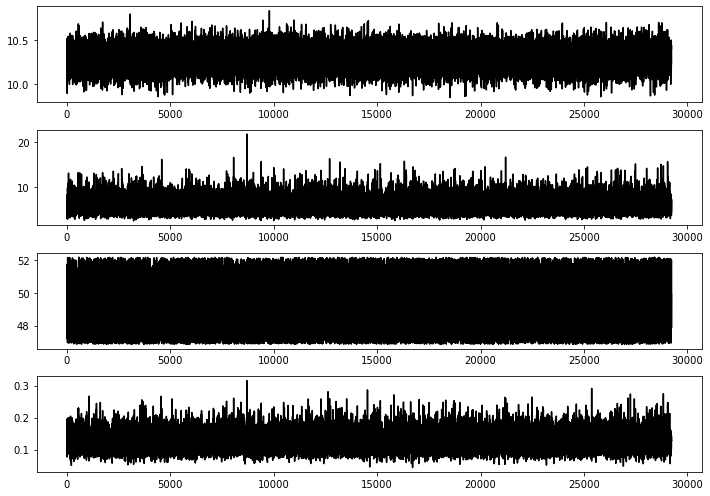

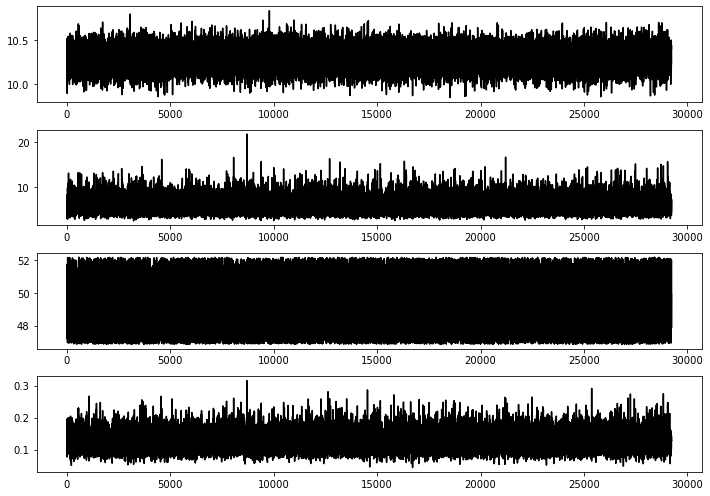

In [35]:
fig, ax= plt.subplots(4, figsize=(10, 7))#, sharex=True)
ax[0].plot(new_samples[:,0], color='black')
ax[1].plot(new_samples[:,1], color='black')
ax[2].plot(new_samples[:,2], color='black')
ax[3].plot(new_samples[:,3], color='black')
#ax1.set_xlabel('N')
#ax1.set_ylabel('Difference value')
#ax1.set_title('Error trend')



fig.tight_layout()
plt.show()

Make a corner plot of the 
4-D parameter space, with labels, credible levels [68-95]% and quantiles, and titles.
#### da sistemare

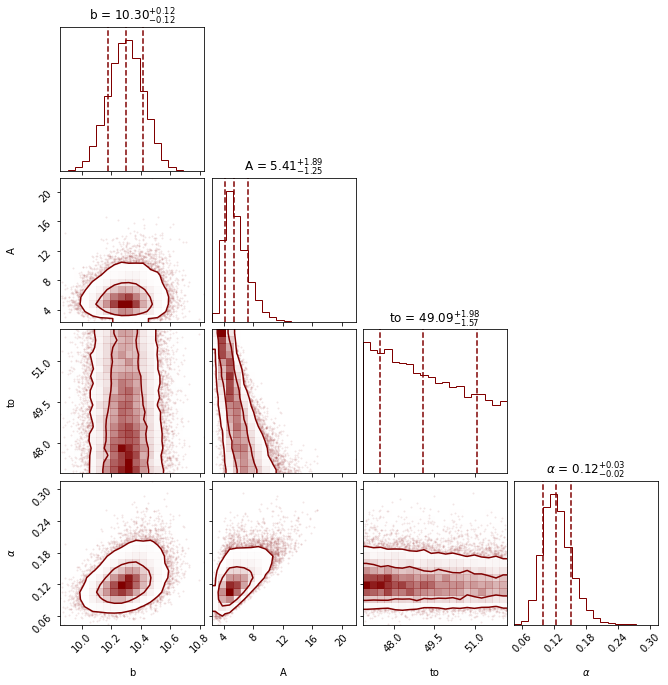

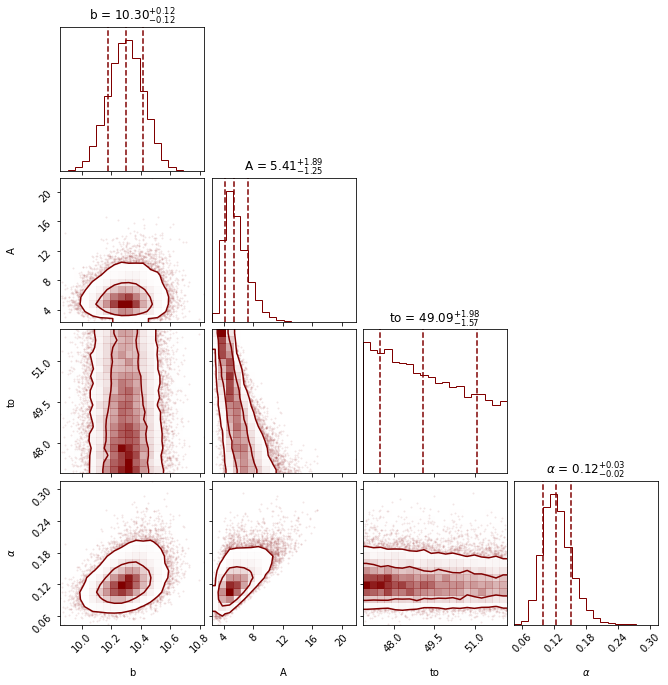

In [116]:
import corner 
labels = ["b", "A", "to", r"$\alpha$"]
fig = corner.corner(new_samples, labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], show_titles= True, color = 'maroon');


Now choose 
 100 samples randomly from your burned, thinned chain and plot the 100
 corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these 100
 burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

Text(0.5, 1.0, 'Qualcosa')

Text(0.5, 1.0, 'Qualcosa')

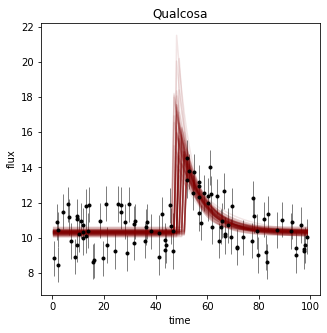

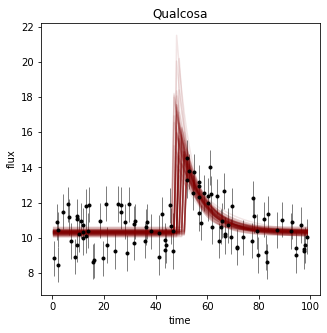

In [94]:
plt.rcParams['figure.figsize'] = [5, 5]
import random
random_samples = np.array(random.sample(new_samples.tolist(), k = 100))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='gray')

xgrid = np.linspace(min(time), max(time), len(time))

[plt.plot(xgrid, model(xgrid, rs), color = 'maroon', alpha = 0.1) for rs in (random_samples)];
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Qualcosa') #da sistemare ------------------------------------------

Let's find the median of each value

In [105]:
median = np.median(new_samples, axis = 0)
print(median)

[10.29767068  5.40973992 49.08834268  0.12254225]
[10.29767068  5.40973992 49.08834268  0.12254225]


We have to find the 90% credibility region

In [109]:
low, med, up = np.percentile(new_samples, [5, 50, 95], axis = 0)
print(low)
print(med)
print(up)

[10.0980812   3.59452375 47.06159762  0.08576882]
[10.29767068  5.40973992 49.08834268  0.12254225]
[10.49494571  8.91100227 51.82419488  0.17700969]
[10.0980812   3.59452375 47.06159762  0.08576882]
[10.29767068  5.40973992 49.08834268  0.12254225]
[10.49494571  8.91100227 51.82419488  0.17700969]


In [113]:
print(str(median) + str(med-low) + str(up-med))

[10.29767068  5.40973992 49.08834268  0.12254225][0.19958948 1.81521617 2.02674506 0.03677343][0.19727503 3.50126235 2.7358522  0.05446744]
[10.29767068  5.40973992 49.08834268  0.12254225][0.19958948 1.81521617 2.02674506 0.03677343][0.19727503 3.50126235 2.7358522  0.05446744]


# Dont use summary statistics, value of exersize are the marginal on different distribution
each line is a posterior sample that correspondes to a single model, to get one model you can take the maximum a posteriori 
taking all the media, these numbers don't correspond to a model 

the media numbers dont live in the four dimension space
You shoul pick a line, come la scegli??? massimizza postiror